![](https://images.aicrowd.com/raw_images/challenges/banner_file/1020/d25db945a27379961cea.png)

<h2><center> Getting Started with Mask Recognition Challenge</center></h2>

In this puzzle, we have detect mask type and bounding box of the mask from the image of human face. 

In this notebook, we'll use the naive approach to prepare the baseline for this puzzle. 


Naive Approach
---

*   We will create bounding box that will detect the face and crop the image as per the co-ordinates of bounding box from image. 
*   Once we've the cropped image(It'll have the image of mask), we'll feed the data to train classifier which will classify the mask.





# Setting up Environment

### Downloading Dataset

So we will first need to download the python library by AIcrowd that will allow us to download the dataset by just inputting the API key. 

In [ ]:
%%capture
!pip install aicrowd-cli

%load_ext aicrowd.magic


## Login to AIcrowd ㊗¶


In [ ]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/24dM8PQYqbc2pXF9DN3V-k7To624IOvhM1jLreSiZxw
API Key valid
Gitlab access token valid
Saved details successfully!



## Download Dataset¶

We will create a folder name data and download the files there.


In [ ]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c mask-prediction -o data

sample_submission.csv:   0%|          | 0.00/44.0k [00:00<?, ?B/s]

test.zip:   0%|          | 0.00/115M [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/193k [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/318M [00:00<?, ?B/s]

val.csv:   0%|          | 0.00/82.8k [00:00<?, ?B/s]

val.zip:   0%|          | 0.00/137M [00:00<?, ?B/s]

In [ ]:
!unzip data/train.zip -d data/ > /dev/null
!unzip data/val.zip -d data/ > /dev/null
!unzip data/test.zip -d data/ > /dev/null

# Importing Libraries

In [ ]:
#Reading the file
import pandas as pd
import numpy as np
import os

# Image Reading & Preprocessing
from PIL import Image, ImageDraw
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Misc.
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestClassifier

# Diving in the dataset 🕵️‍♂️

In [ ]:
train_images = 'data/train'
val_images = 'data/val'
test_images = 'data/test'

In [ ]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")

In [ ]:
train_df.head()

ImageID                  bbox  masktype
0   k8o0f   [73, 197, 293, 400]       N95
1   7a0l9   [47, 364, 300, 512]  surgical
2   wfp7p  [203, 221, 380, 403]       N95
3   7qaw6   [87, 210, 322, 385]  surgical
4   i4kqj  [227, 283, 479, 475]  surgical

In [ ]:
train_df.loc[train_df.masktype == "cloth"][:2]

ImageID                 bbox masktype
5    uokc1   [3, 240, 276, 441]    cloth
13   qzbds  [91, 321, 380, 512]    cloth

In [ ]:
train_img = os.listdir(train_images)
train_img[:5]

['urko1.jpg', 'ngb1h.jpg', 'u54pu.jpg', 'wvkoh.jpg', 'ou7fd.jpg']

From the above, we can see that ImageId is image_name without extensions(.jpg).

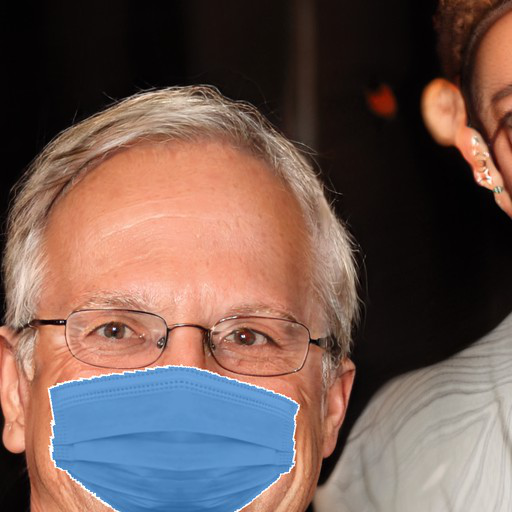

In [ ]:
img = Image.open(os.path.join(train_images, '7a0l9.jpg'))
img

# Image Preprocessing

In this section we are going to learn some opencv functions which can help us detecting the mask from the image!

In [ ]:
# Converting the image to numpy array 
np_img= np.array(img)
np_img.shape

(512, 512, 3)

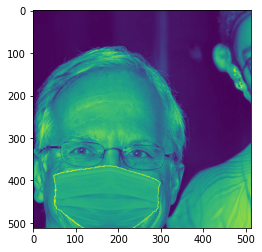

In [ ]:
# Converting the Image to RGB to Grayscale ( black/white )
gray= cv2.cvtColor(np_img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

### `cv2.Canny`

Now `cv2.Canny` is Canny Edge Detection which helps us to detect edges in the image. Let's try it our on the image

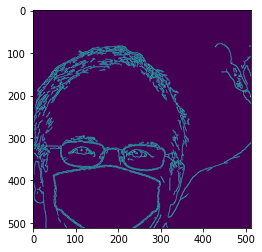

In [ ]:
canny= cv2.Canny(gray, 120,250)
plt.imshow(canny)

So as you can see the function detected edges including the mask and some noise too, there are many ways to reduce that noise, however you can try changing the parameters in the function and see where that leads. 

### Countours

Contours are lines joining along the bounding of a intensity or color in an image. In the canny image or the original image, we see that the image has much different color as compared to the sky. 

In [ ]:
# Finding contours in the image
contours, hierarchy = cv2.findContours(canny, 
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [ ]:
# Sorting the contours in ascending order
contours = sorted(contours, key=cv2.contourArea)

In [ ]:
# Getting the bounding boxes of the biggest contours
x,y,w,h = list(cv2.boundingRect(contours[-1]))
x,y,w,h 

(47, 304, 253, 208)

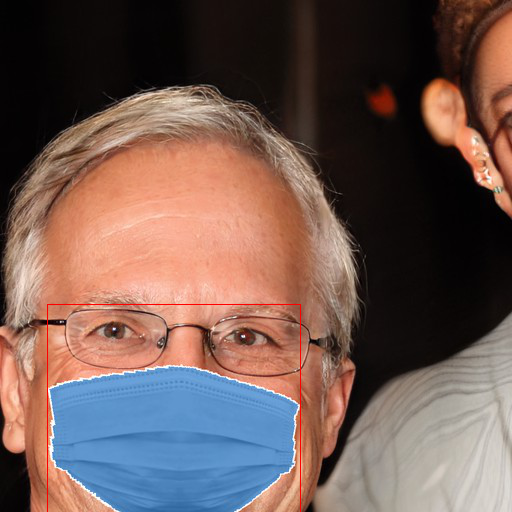

In [ ]:
# Showing the contour
draw_img = img.copy()
draw = ImageDraw.Draw(draw_img)
draw.rectangle([x,y,x+w,y+h ], outline ="red")
draw_img

So as you can see, fnding contours did a pretty great job in finfing the mask.

In [ ]:
left,top,right, bottom = x,y,x+w,y+h

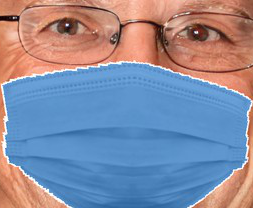

In [ ]:
mask = img.crop((left,top,right, bottom))
mask

In [ ]:
mask = mask.convert('L')
mask1 = np.asarray(mask)
mask1.shape

(208, 253)

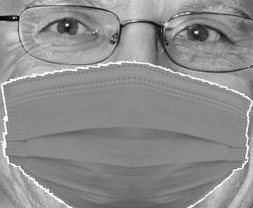

In [ ]:
mask

----
Now, we will create a function which will perform the all things which we've done previous cells.

In [ ]:
def gen_bounding_boxes_and_mask(img):

  # Converting the image to numpy array 
  np_img = np.array(img)
  gray = cv2.cvtColor(np_img, cv2.COLOR_BGR2GRAY)

  # Getting the edges
  canny = cv2.Canny(gray, 100, 200)

  # Getting the contours
  contours, hierarchy = cv2.findContours(canny, 
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  # Sorting the contours
  contours = sorted(contours, key=cv2.contourArea)

  try:
    # Return the boundong boxes of the biggest contour
    x,y,w,h = list(cv2.boundingRect(contours[-1])) 
  # Incase no countous found
  except:
    x,y,w,h = [1, 1, 1, 1]
  left,top,right, bottom = x,y,x+w,y+h
  mask = img.crop((left,top,right, bottom))

  return x,y,w,h, mask

Preprocessor
----
Prepare data for feeding the model by using function `gen_bounding_boxes_and_mask`.

In [ ]:
def preprocessor(image_path,dataframe):
  bboxes = []
  image_ids = []
  mask_type = []
  # Ground through each test image
  # for i in range(len(df_list)):
  for i in tqdm(range(dataframe.shape[0])):
    # Reading the test image
    img = Image.open(os.path.join(image_path, list(dataframe['ImageID'])[i]+'.jpg'))

    # Generating the bounding boxes
    x,y,w,h,mask = gen_bounding_boxes_and_mask(img)

    #Convert to grayscale
    mask = mask.convert('L')

    #Reshapes the image to a fix sahpe -> 190×190(You can choose any shape)
    mask = mask.resize((190,190))
    mask = np.asarray(mask)

    #Squeezes the matrix for feeding the value to model
    mask = np.squeeze(mask[10,:])
 

    mask_type.append(mask)
    
    # Adding the boundong boxes and image id
    bboxes.append([x,y,x+w,y+h])
    # image_ids.append(test_imgs[i].split(".")[0])
  if image_path == test_images:
      dataframe['bbox'] = bboxes
  else:
      dataframe['pred_bbox'] = bboxes
  dataframe['imgData'] = mask_type
  return dataframe

In [ ]:
train_final_df = preprocessor(train_images,train_df)

  0%|          | 0/5600 [00:00<?, ?it/s]

In [ ]:
train_final_df.head()

ImageID  ...                                            imgData
0   k8o0f  ...  [252, 235, 243, 250, 236, 239, 249, 253, 250, ...
1   7a0l9  ...  [156, 155, 159, 154, 153, 156, 157, 153, 151, ...
2   wfp7p  ...  [181, 187, 185, 189, 191, 191, 195, 195, 193, ...
3   7qaw6  ...  [80, 80, 84, 96, 112, 111, 112, 136, 148, 165,...
4   i4kqj  ...  [166, 166, 167, 167, 167, 167, 167, 167, 167, ...

[5 rows x 5 columns]

# Model

In [ ]:
train_final_df['imgData'][12].shape

(190,)

In [ ]:
X = train_final_df.imgData
y = train_final_df.masktype

In [ ]:
X.shape,y.shape

((5600,), (5600,))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
mask_type_predictor = RandomForestClassifier(max_features=0.15, random_state=2)
mask_type_predictor.fit(list(X),y)

RandomForestClassifier(max_features=0.15, random_state=2)

In [ ]:
print(mask_type_predictor.score(list(X),y))

1.0


In [ ]:
val_final_df = preprocessor(val_images,val_df)
val_x = val_final_df.imgData
val_y = val_final_df.masktype

  0%|          | 0/2400 [00:00<?, ?it/s]

In [ ]:
val_predict = mask_type_predictor.predict(list(val_x))

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
print(f1_score(val_predict,val_y,average='weighted'))

0.405815690267701


# Submitting Results 📄

In [ ]:
test_df = pd.DataFrame()
n_test_image = os.listdir(test_images)

In [ ]:
test_df['ImageID'] = [img_name.split(".")[0] for img_name in n_test_image]

In [ ]:
test_df.head()

ImageID
0   kcm7j
1   3cx5o
2   nprs0
3   l1h4z
4   s22rp

In [ ]:
test_df = preprocessor(test_images,test_df)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
test_df.head()

ImageID  ...                                            imgData
0   kcm7j  ...  [88, 88, 96, 118, 134, 132, 123, 125, 138, 146...
1   3cx5o  ...  [31, 31, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...
2   nprs0  ...  [85, 83, 82, 65, 44, 36, 38, 43, 36, 28, 37, 5...
3   l1h4z  ...  [199, 199, 201, 203, 205, 206, 207, 210, 210, ...
4   s22rp  ...  [103, 102, 100, 97, 95, 95, 96, 97, 97, 94, 92...

[5 rows x 3 columns]

In [ ]:
pred = mask_type_predictor.predict(list(test_df.imgData))

Adding prediction to test dataframe in a separate column named masktype.

In [ ]:
test_df['masktype'] = pred

For submission, we've to drop `imgData` column.

In [ ]:
test_df.drop(['imgData'], axis=1, inplace = True)
test_df.head()

ImageID                  bbox  masktype
0   kcm7j  [130, 331, 306, 405]     cloth
1   3cx5o  [135, 330, 262, 512]  surgical
2   nprs0    [76, 46, 383, 374]     cloth
3   l1h4z  [217, 182, 488, 364]  surgical
4   s22rp  [106, 426, 206, 512]      KN95

In [ ]:
test_df

ImageID                  bbox  masktype
0      kcm7j  [130, 331, 306, 405]     cloth
1      3cx5o  [135, 330, 262, 512]  surgical
2      nprs0    [76, 46, 383, 374]     cloth
3      l1h4z  [217, 182, 488, 364]  surgical
4      s22rp  [106, 426, 206, 512]      KN95
...      ...                   ...       ...
1995   6nri1     [0, 40, 100, 168]       N95
1996   61f1v  [162, 400, 437, 512]     cloth
1997   ew5ih   [62, 208, 309, 384]  surgical
1998   scarx  [113, 255, 421, 454]     cloth
1999   ke4zq  [223, 170, 489, 379]      KN95

[2000 rows x 3 columns]

In [ ]:
!rm -rf assets
!mkdir assets

test_df.to_csv(os.path.join("assets", "submission.csv"), index=False)

**Note : Please make sure that there should be filename `submission.csv` in `assets` folder before submitting it**

## Uploading the Results

In [ ]:
%aicrowd notebook submit -c mask-prediction -a assets --no-verify

Using notebook: Baseline for Mask Prediction for submission...
Removing existing files from submission directory...
Scrubbing API keys from the notebook...


Output()

╭─────────────────────────╮                                                   
                                                  │ Successfully submitted! │                                                   
                                                  ╰─────────────────────────╯

                                                        Important links                                                         
┌──────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/mask-prediction/submissions/172685              │
│                  │                                                                                                           │
│  All submissions │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/mask-prediction/submissions?my_submissions=true │
│                  │                                                                                                           │
│      Leaderboard │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/mask-prediction/leaderboards                    │
│                  │                                                                                                           │
│ Discussion forum │ https://discourse.aicrowd.com/c/ai-blitz-xiii                                                             │
│                  │                                                                                                           │
│   Challenge page │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/mask-prediction                                 │
└──────────────────┴───────────────────────────────────────────────────────────────────────────────────────────────────────────┘